In [1]:
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats

In [2]:
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3', 
    chunks={'time': 48},
    storage_options=dict(token='anon'),
)

ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-09-22 01:57:27.339380+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-16

In [3]:
daily_sfctp = ds['total_precipitation'].resample(time='D').sum()

daily_sfctp

<xarray.DataArray 'total_precipitation' (time: 31167, latitude: 721,
                                         longitude: 1440)> Size: 129GB
dask.array<stack, shape=(31167, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 249kB 1940-01-01 1940-01-02 ... 2025-04-30
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [4]:
daily_sfctp_avl = daily_sfctp.sel(latitude=slice(35.6+2.5,35.6-2.5),longitude=slice(360-82.5-2.5,360-82.5+2.5)
                                  ,time=slice('2015-04-30','2025-04-30'))

daily_sfctp_avl = daily_sfctp_avl.persist()

Text(0, 0.5, 'Precipitation (mm)')

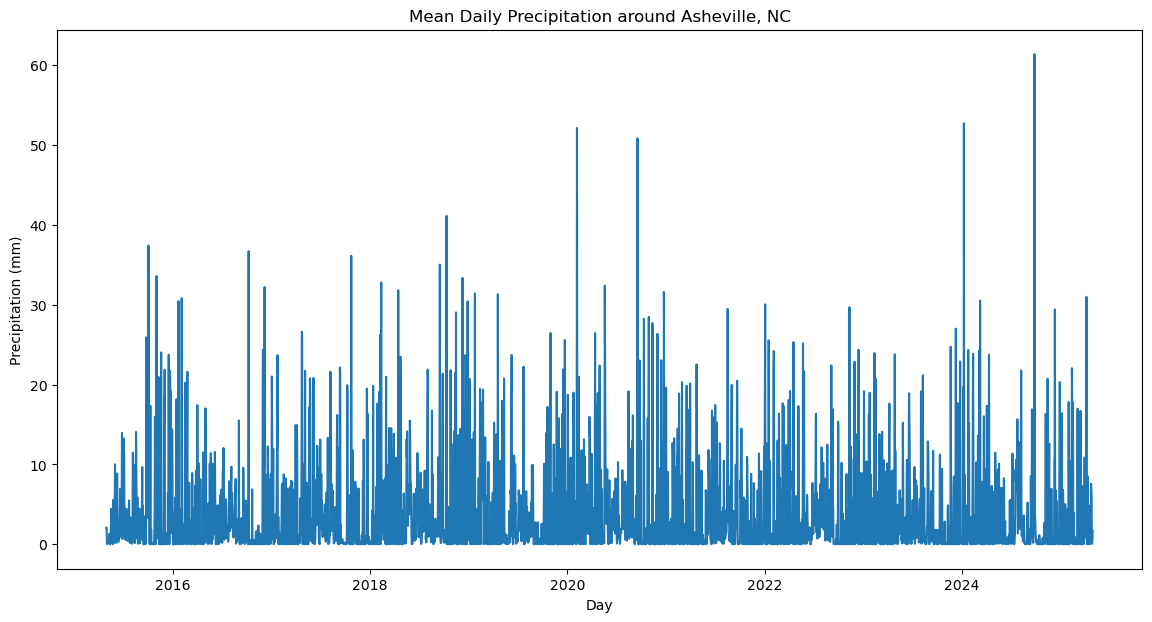

In [5]:
fig, ax = plt.subplots(figsize=(14,7))

daily_sfctp_avlavgmm = daily_sfctp_avl.mean(dim=['latitude','longitude']).compute()*1000

cs = ax.plot(daily_sfctp_avl['time'],daily_sfctp_avlavgmm)
ax.set_title('Mean Daily Precipitation around Asheville, NC')
ax.set_xlabel('Day')
ax.set_ylabel('Precipitation (mm)')

In [6]:
q95 = daily_sfctp_avlavgmm.quantile(0.95)

q95

<xarray.DataArray 'total_precipitation' ()> Size: 8B
array(16.03820524)
Coordinates:
    quantile  float64 8B 0.95

In [7]:
daily_sfctp_avl_95 = daily_sfctp_avlavgmm.where(daily_sfctp_avlavgmm >= q95, drop=True)

daily_sfctp_avl_95

<xarray.DataArray 'total_precipitation' (time: 183)> Size: 732B
array([25.917114, 20.70884 , 37.419155, 27.358904, 17.349442, 33.59364 ,
       20.955086, 24.034382, 18.485699, 21.864168, 23.743343, 21.719654,
       18.662384, 19.15451 , 18.176144, 30.45557 , 30.823145, 20.221111,
       21.610056, 17.425865, 17.02335 , 36.710777, 16.364492, 24.350702,
       32.214394, 21.023191, 23.677994, 26.616602, 26.360676, 21.729107,
       17.158232, 20.779495, 18.060051, 20.834345, 21.61517 , 16.186684,
       22.146685, 21.721994, 19.932116, 18.816433, 36.14054 , 19.494387,
       16.341623, 19.83723 , 17.62744 , 19.10305 , 26.228752, 32.816395,
       20.979227, 31.819773, 23.493319, 19.374672, 18.226965, 21.880402,
       20.283773, 16.729591, 35.03414 , 18.946884, 21.379944, 41.133965,
       21.807487, 21.464972, 29.045029, 33.36403 , 16.97857 , 23.701586,
       22.881073, 30.431437, 20.716753, 31.413582, 19.462307, 17.806482,
       19.37443 , 31.32713 , 17.96726 , 20.757633, 19.609585, 19.167398,
       23.71838 , 22.239315, 17.201494, 18.41711 , 26.46443 , 19.101284,
       16.321514, 21.880077, 25.579308, 18.725103, 18.994371, 52.147923,
       16.061926, 20.077892, 20.974922, 26.455826, 17.556957, 18.936508,
       22.379665, 32.40518 , 23.087616, 19.159128, 16.14633 , 50.8483  ,
       23.019882, 28.246216, 28.47399 , 27.715942, 26.748608, 26.362774,
       23.049513, 31.60846 , 19.60666 , 18.89042 , 20.29155 , 19.855907,
       16.880194, 20.133972, 22.527805, 16.739542, 17.438402, 29.476479,
       19.96024 , 20.470257, 16.526432, 22.21092 , 30.056477, 25.543968,
       21.669846, 24.206272, 16.361414, 17.663893, 17.32473 , 18.07105 ,
       19.201628, 25.324652, 17.29844 , 25.165663, 21.66035 , 16.339045,
       22.40233 , 16.913364, 29.692371, 22.856434, 24.367386, 19.171774,
       16.320675, 18.985016, 23.946898, 20.700373, 17.62738 , 23.797577,
       18.918055, 19.14144 , 21.174812, 24.736004, 27.005869, 17.679249,
       22.894665, 19.68669 , 52.748756, 24.332077, 16.560562, 23.847992,
       24.255243, 30.54022 , 17.330446, 23.77433 , 21.785063, 16.89769 ,
       20.682373, 61.393387, 60.85563 , 16.337557, 20.736126, 29.410448,
       20.319693, 16.416069, 17.800104, 22.058386, 17.396177, 17.771664,
       16.952316, 16.699785, 30.995409], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1kB 2015-09-25 2015-09-29 ... 2025-04-07
    quantile  float64 8B 0.95

Text(0.5, 0, 'Precipitation (mm)')

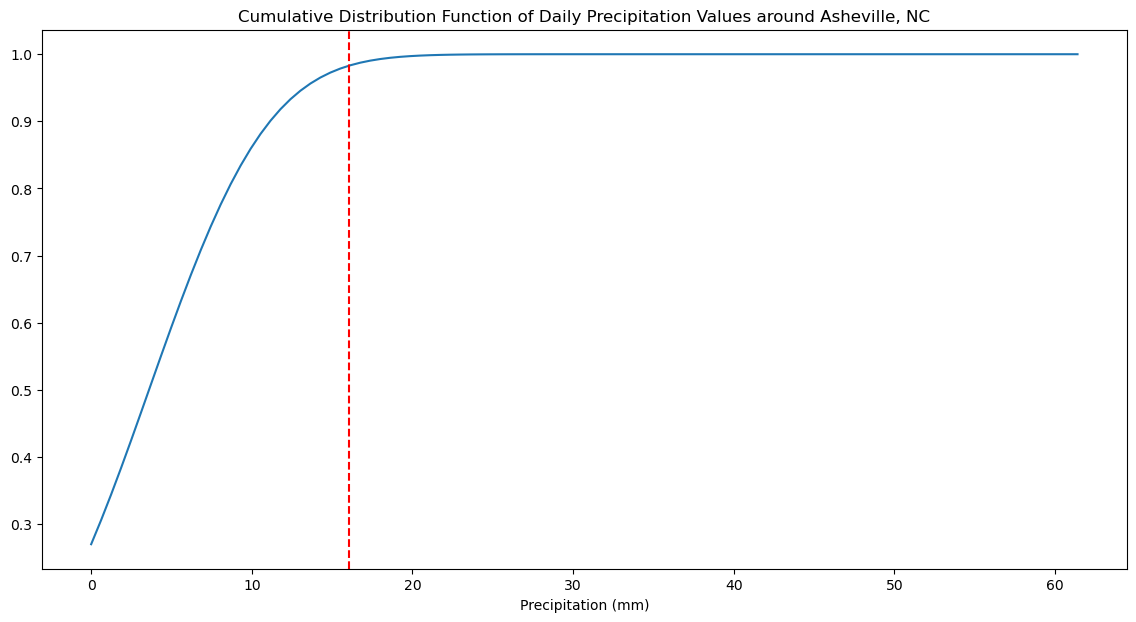

In [8]:
fig, ax = plt.subplots(figsize=(14,7))

mu, std = stats.norm.fit(daily_sfctp_avlavgmm.values.flatten())
x = np.linspace(daily_sfctp_avlavgmm.min(), daily_sfctp_avlavgmm.max(), 100)
cdf = stats.norm.cdf(x, loc=mu, scale=std)

ax.plot(x, cdf)
ax.axvline(q95, color='r', linestyle='--')
ax.set_title('Cumulative Distribution Function of Daily Precipitation Values around Asheville, NC')
ax.set_xlabel('Precipitation (mm)')

In [9]:
daily_sfctp_95 = daily_sfctp.sel(time=daily_sfctp_avl_95.time).mean(dim='time').compute()

daily_sfctp_95mm = daily_sfctp_95*1000
daily_sfctp_95mm

<xarray.DataArray 'total_precipitation' (latitude: 721, longitude: 1440)> Size: 4MB
array([[0.67730284, 0.67730284, 0.67730284, ..., 0.67730284, 0.67730284,
        0.67730284],
       [0.6729822 , 0.67299545, 0.67300314, ..., 0.67283714, 0.67290276,
        0.6729536 ],
       [0.65934926, 0.6593747 , 0.65942824, ..., 0.6593277 , 0.6594669 ,
        0.65946096],
       ...,
       [0.17655626, 0.17657329, 0.17656702, ..., 0.17654575, 0.17655803,
        0.176563  ],
       [0.17126133, 0.17116371, 0.17114958, ..., 0.17121108, 0.17120448,
        0.17122391],
       [0.1865061 , 0.1865061 , 0.1865061 , ..., 0.1865061 , 0.1865061 ,
        0.1865061 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    quantile   float64 8B 0.95

In [10]:
daily_sfctp_1981_2010 = daily_sfctp.sel(time=slice('1981-01-01','2010-12-31')).mean(dim=['time']).compute()

daily_sfctp_1981_2010 = daily_sfctp_1981_2010*1000

daily_sfctp_1981_2010

<xarray.DataArray 'total_precipitation' (latitude: 721, longitude: 1440)> Size: 4MB
array([[0.6998418 , 0.6998418 , 0.6998418 , ..., 0.6998418 , 0.6998418 ,
        0.6998418 ],
       [0.7070862 , 0.7070888 , 0.70710695, ..., 0.70700604, 0.70701766,
        0.7070342 ],
       [0.6978474 , 0.69790673, 0.6979504 , ..., 0.69766146, 0.69769555,
        0.69774246],
       ...,
       [0.17811626, 0.17810033, 0.17807356, ..., 0.17810853, 0.17811646,
        0.17812091],
       [0.17806347, 0.17798144, 0.17798018, ..., 0.17811169, 0.17810425,
        0.17809777],
       [0.19077408, 0.19077408, 0.19077408, ..., 0.19077408, 0.19077408,
        0.19077408]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [11]:
daily_sfctp_anom = daily_sfctp_95mm - daily_sfctp_1981_2010

In [12]:
lat = daily_sfctp_95mm['latitude']
lon = daily_sfctp_95mm['longitude']

Text(0.5, 1.0, 'Composite Mean Precipitation on days of 95th precentile daily precipitation in the Asheville, NC area')

/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


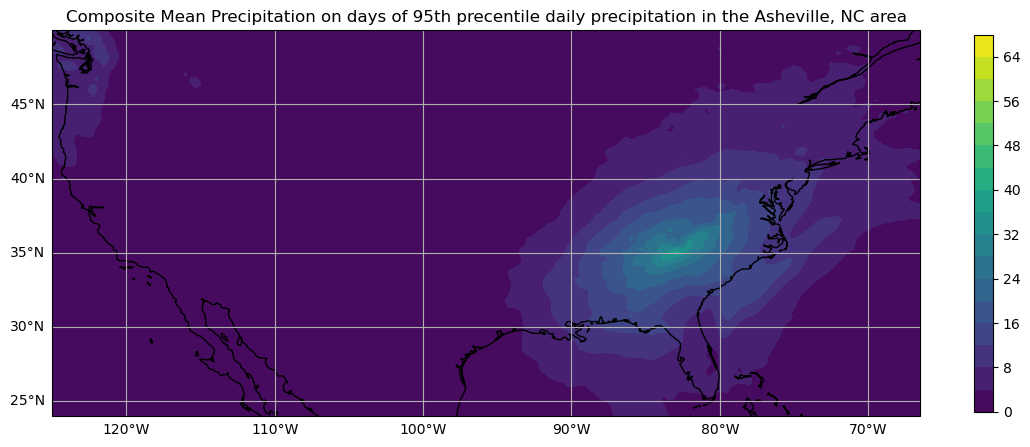

In [13]:
fig,ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

X,Y = np.meshgrid(lon,lat)
cs = ax.contourf(X,Y,daily_sfctp_95mm,levels=20,transform=ccrs.PlateCarree())
cb = fig.colorbar(cs,shrink=0.7)
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_title('Composite Mean Precipitation on days of 95th precentile daily precipitation in the Asheville, NC area')


Text(0.5, 1.0, 'Anomaly from the 1981-2010 Mean')

/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


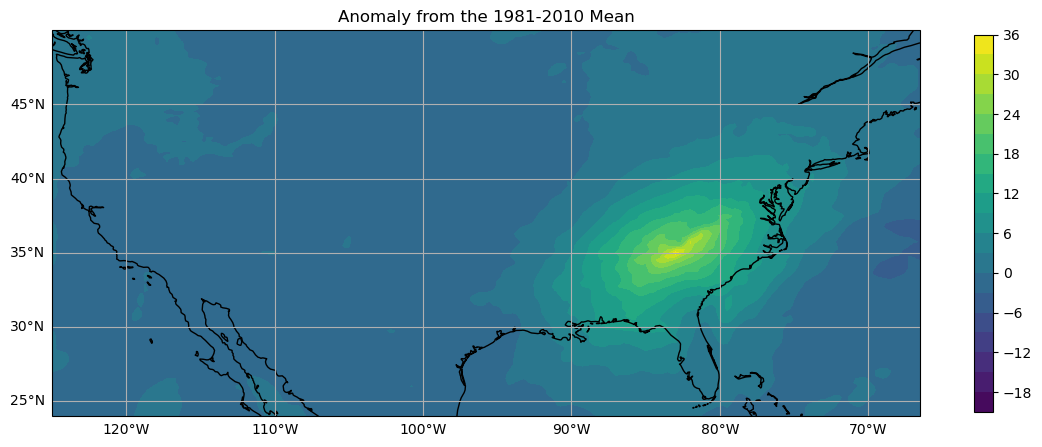

In [15]:
fig,ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

X,Y = np.meshgrid(lon,lat)
cs = ax.contourf(X,Y,daily_sfctp_anom,levels=20,transform=ccrs.PlateCarree())
cb = fig.colorbar(cs,shrink=0.7)
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_title('Anomaly from the 1981-2010 Mean')